<a href="https://colab.research.google.com/github/15108326/ANAE/blob/master/ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
rdkit is already installed


In [0]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
try:

    %tensorflow_version 1.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [4]:
smifile = "GDBMedChem.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","No"])
data=data[0:200000]
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(150000,)
(50000,)


In [5]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str( charset))
print(len(charset), embed)

{'F', 'o', 'N', 'n', '-', 'l', '1', '=', '!', '(', 'C', '[', 's', 'E', '3', 'O', 'S', '#', ']', '2', ')', 'H', '+', 'c'}
24 58


CC1C([NH3+])C1NC1(C)CCC[NH2+]C1


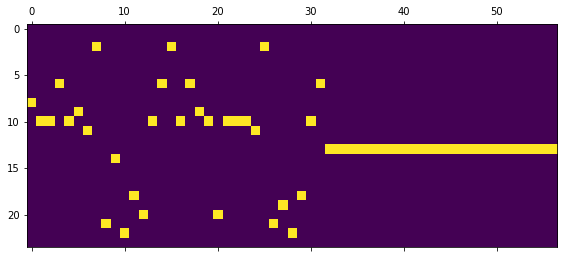

In [6]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [7]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!CC1C([NH3+])C1NC1(C)CCC[NH2+]C1EEEEEEEEEEEEEEEEEEEEEEEEE'

In [8]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

Using TensorFlow backend.


In [9]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [10]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 57, 24)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  22784       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]        

In [11]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [12]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [13]:
model.fit([X_train,X_train],Y_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 150000 samples, validate on 50000 samples
Epoch 1/10





150000/150000 [==============================] - 106s 707us/step - loss: 0.6487 - val_loss: 0.4939
Epoch 2/10
150000/150000 [==============================] - 101s 673us/step - loss: 0.4571 - val_loss: 0.4233
Epoch 3/10
150000/150000 [==============================] - 99s 661us/step - loss: 0.4103 - val_loss: 0.3873
Epoch 4/10
150000/150000 [==============================] - 99s 659us/step - loss: 0.3773 - val_loss: 0.3576
Epoch 5/10
150000/150000 [==============================] - 99s 659us/step - loss: 0.3474 - val_loss: 0.3664
Epoch 6/10
150000/150000 [==============================] - 98s 656us/step - loss: 0.3192 - val_loss: 0.3009
Epoch 7/10
150000/150000 [==============================] - 98s 654us/step - loss: 0.2958 - val_loss: 0.2852
Epoch 8/10
150000/150000 [==============================] - 98s 656us/step - loss:

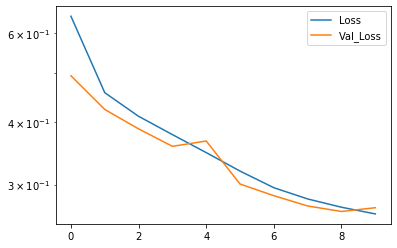

In [14]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [15]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)

CC(O)C(O)C1=CCC(O)C1C#CEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)C(C)C1CCC((C)C1C#CEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1=CC2N(C1)C(=O)CNC(=O)C2(C)CEEEEEEEEEEEEEEEEEEEEEEEEEE CC1=CC2((CC)C(=O)C(C(=O)CCCC)CEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1(CC1)C1=C2NCC=CC=C2NC1=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1(CCC)C1=CCCCC=CC2CCCC1=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1=CCC=CC2C=CC1C2=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1=CCC=CCCCCCCCC2=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC(O)(CNC=O)C([NH3+])C=CC#NEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)(CCCCO)C(CNH3+])CCCC#NEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1(C)CCC2=C1CCCC(C2)=NOEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1(C)CC==CCCC((((=))=NOEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC(O)C1CC2C[NH+]1CCCOC2CEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)C1CCC([NH2](CCCCCC=EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC(C)c1n[nH]c(NCC(=O)C#C)c1CEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(C)(1ccnH]c(CCC#=O)C#C)c1CEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1=CCC2CC=CCC1C2C(O)C1CC1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1=CCC==CCCC((((((C)CCCC1EEEEE

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [0]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [0]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


In [0]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

In [20]:
sample_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (1, 1, 24)                0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                22784     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 24)                1560      
Total params: 24,344
Trainable params: 24,344
Non-trainable params: 0
_________________________________________________________________


In [27]:
x_latent = smiles_to_latent_model.predict(X_test);x_latent

array([[0.       , 5.5927725, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.5801219, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 5.2605615, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

[    5 10271 22605 34077 22392 25035 48550  5675  1983  1362]
23677        CC1(C)CCC2=C1CCCC(C2)=NO
113201        CC1(C)CC=CC2CC(O)C=CC12
142834        CC1(C)CC2CC=CC2NC(=O)C1
53460         CC1(C)CC2CC3CC=C(C1)C23
135482       CC1(C)CC=CC=C(CC#C1)NC=O
8601          CC1(C)CC2=CCOCC(=O)C1C2
16742     CC1(CCCCOC2OCCC2O)CC1[NH3+]
91619     CC1(COC1)C1=CCOCCCCC1[NH3+]
Name: smiles, dtype: object


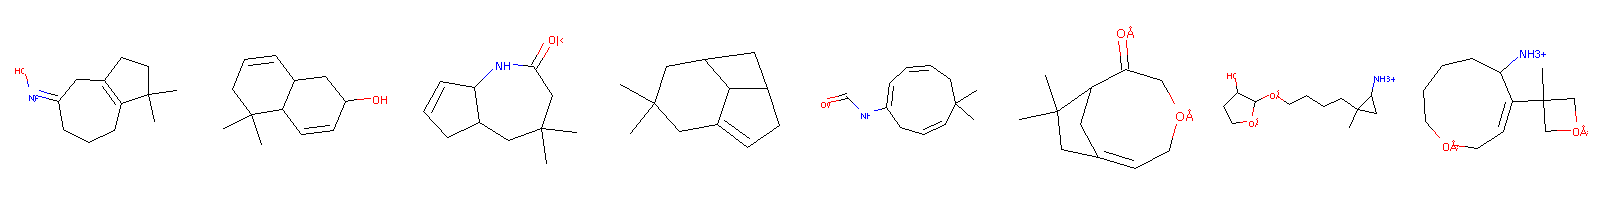

In [22]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

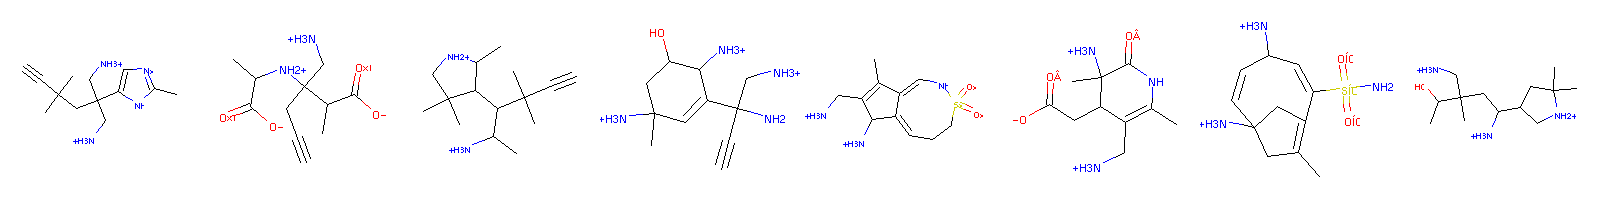

In [23]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.4830112  0.26642764] 0.7494388


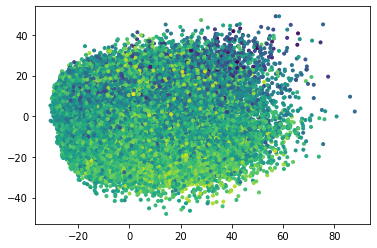

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

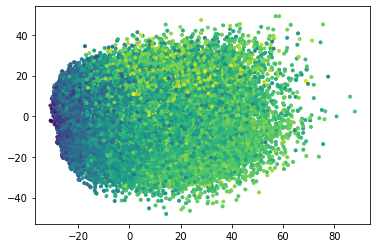

In [26]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [0]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

In [0]:
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")


In [30]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=100, callbacks = [rlr])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/100
150000/150000 [==============================] - 4s 24us/step - loss: 1.8772
Epoch 2/100
  6400/150000 [>.............................] - ETA: 3s - loss: 1.7804

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


150000/150000 [==============================] - 3s 22us/step - loss: 1.7529
Epoch 3/100
150000/150000 [==============================] - 3s 22us/step - loss: 1.7085
Epoch 4/100
150000/150000 [==============================] - 3s 21us/step - loss: 1.6621
Epoch 5/100
150000/150000 [==============================] - 3s 22us/step - loss: 1.6401
Epoch 6/100
150000/150000 [==============================] - 3s 22us/step - loss: 1.6258
Epoch 7/100
150000/150000 [==============================] - 3s 22us/step - loss: 1.6070
Epoch 8/100
150000/150000 [==============================] - 3s 22us/step - loss: 1.5860
Epoch 9/100
150000/150000 [==============================] - 3s 21us/step - loss: 1.5713
Epoch 10/100
150000/150000 [==============================] - 3s 21us/step - loss: 1.5593
Epoch 11/100
150000/150000 [==============================] - 3s 21us/step - loss: 1.5457
Epoch 12/100
150000/150000 [==============================] - 3s 21us/step - loss: 1.5341
Epoch 13/100
150000/150000 [==

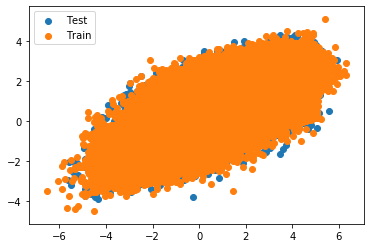

In [31]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()


In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,24))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,24))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [33]:
smiles = latent_to_smiles(x_latent[0:1])
print(smiles)
print(smiles_test.iloc[0])

CC(O)C(C)C1CCCCCCC1(C)C
CC(O)C(O)C1=CCC(O)C1C#C


In [34]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))


CC1=CC2(CC(C)C2)C(C)(C)C=CCC
CC(O)C1CCC(C)(C)C1[NH+]=C1
CC(C)(C)C(C)(C)C(C)(C)C([O-]
CC(O)C1CC(C)(C)C(C[NH3+])C1(
CC(C)C1CC(C)(C[NH3+])C([NH3+
CC12CCC1CC(CCCCCC(C)=O)C(C)=
CC(C)(C)C(C)C1CC(C)(C)CC(C)O
Cc1cc2ccc(CCC#C)ccc2[nH]1
CC(O)C1(CC(C)=C1C[NH3+])C1CC
CC1=C2C(CC([NH3+])C2)C(C)(C)
Cc1cccc2CCCCC[NH+]2C1
CC1=CC=CCCC(C)(C)C(C[NH3+])=
CC1=CC(C[NH3+])C2(CC2)C(C)=C
CC1=CCC(=O)C(C)(C)CCCC1[NH3+
CC1(C)CC(CC(CO)C1O)[NH+]=C3
CC(O)(C#N)C1CCC=CC=CC=CCC1C#
CC1(CC([NH3+])C(C)(C)C1)C1CC
CC12CC=CCC(CC(C)(C)C1[NH3+])
Cc1occ2CCCC[NH+]2C1
CC1([NH3+])CCCCC(CC1)C([NH3+
CC1=CC[NH+](C)C(C[NH3+])C(C)
CC1=C(C[NH3+])CC(=O)C2CCC2CC
CC1C([NH3+])C(C)(C)C(C)(C)C(
Cc1cc(cc(C)c1C)c1cc(C)c(C)c(
CC1C2C(C)C(C)=C(C)C(C[NH3+])
CC([NH3+])C(C)C(C)C1CC(C)(C)
Cc1[nH]c(CCCC(C)(C)C)c2ccc(C
Cc1cc(CC2CCCC2)c2CC=CCc12
CC1C2CC=CC(C)(C)C(C)=CC1(C)C
CC1(CC([NH3+])C1O)C(=O)C(N)=
CC1C(CC[NH3+])C(C)(C)C(C)(C)
CC1=CC(C)(C)C(C)=C(C)C=CC(=O
CC(=O)C1=CC(C)(C)C(C)(C)[NH+
CC1=C2CCC=CC(C[NH3+])(C[NH2+
CC(O)C1CCC2C[NH+](C)CC(C)(C)
Cc1cccc(CC

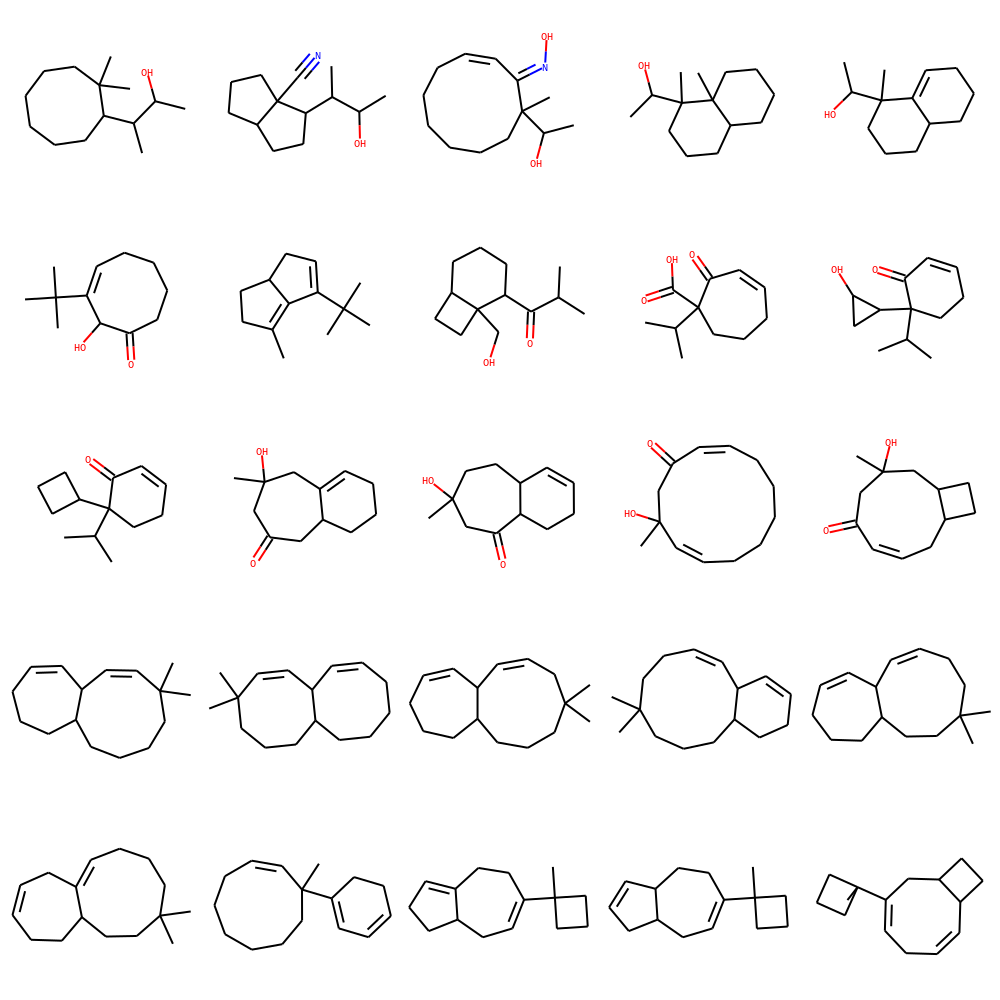

In [35]:
#Interpolation test in latent_space
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

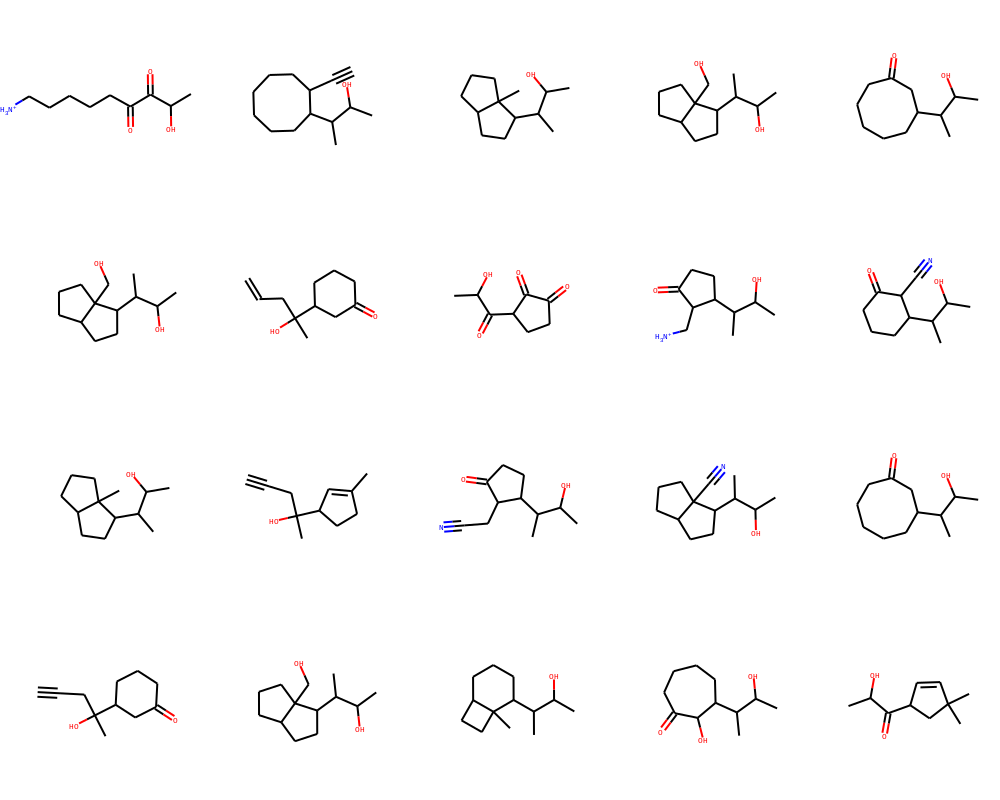

In [36]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)